In [1]:
# Prepare all imports, write relevant functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

def melt_data(df):
    melted = pd.melt(df, id_vars=['CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})


def eval_arima(ts,order):
    train_len=int(.8*len(ts))
    ts_train=ts[:train_len]
    ts_test=ts[train_len:]
    
    history=[x for x in ts_train]
    predictions=[]
    
    for t in range(len(ts_test)):
        model=ARIMA(history,order=order)
        model_fit=model.fit(disp=0)
        yhat=model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(ts_test[t])
    error=mean_squared_error(ts_test,predictions)
    return error


def arima_gridsearch(ts,Pvec,Dvec,Qvec):
    Best_score,Best_pdq=float('inf'),None
    for p in Pvec:
        for d in Dvec:
            for q in Qvec:
                order=(p,d,q)
                try:
                    mse=eval_arima(ts,order)
                    if mse<Best_score:
                        Best_score,Best_pdq=mse,order
                    print(f"Arima{order} MSE={mse}")
                except:
                    continue
    return Best_pdq

In [2]:
#Prepare and clean data

url=r'zillow_data.csv'
data=pd.read_csv(url)

data.rename(columns={'RegionName':'Zip'},inplace=True)

data.index=data.Zip
data.drop(['RegionID','SizeRank','Zip'],axis=1,inplace=True)

data.head()

,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Zip,,,,,,,,,,,,,,,,,,,,,
60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#For the sake of tractability, only NYC zipcodes will be considered
df=data[data.City=='New York']
df.drop(['City','State','Metro'],axis=1,inplace=True)
df.head(10)

,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Zip,,,,,,,,,,,,,,,,,,,,,
10467,Bronx,152900.0,152700.0,152600.0,152400.0,152300.0,152000.0,151800.0,151600.0,151600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
11226,Kings,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
11375,Queens,252400.0,251800.0,251400.0,251200.0,251100.0,251000.0,251000.0,251200.0,251700.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
11235,Kings,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
10011,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
10128,New York,3676700.0,3704200.0,3729600.0,3754600.0,3781800.0,3813500.0,3849600.0,3888900.0,3928800.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
10462,Bronx,154300.0,154300.0,154400.0,154400.0,154500.0,154400.0,154500.0,154500.0,154800.0,...,432800,436100,439900,443500,444100,443900,446000,446400,447200,450200
10456,Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
10463,Bronx,180100.0,181000.0,181900.0,182600.0,183200.0,183700.0,184400.0,185100.0,186100.0,...,680800,684500,692000,700900,710200,726900,744500,757000,769400,778700


In [4]:
df.CountyName.value_counts()

Queens      55
Kings       28
Bronx       13
Richmond    12
New York     6
Name: CountyName, dtype: int64

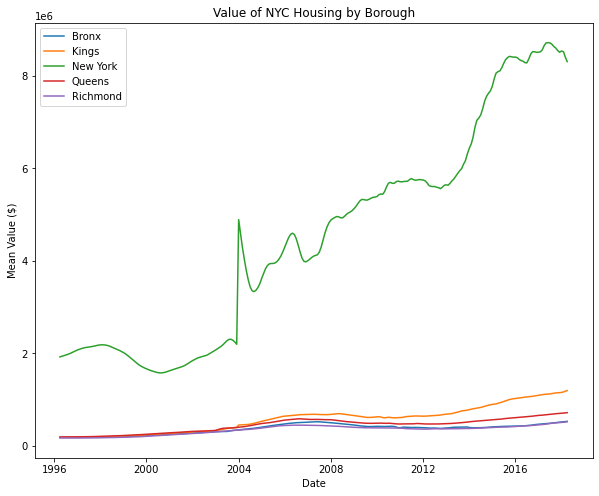

In [5]:
#Let's check out the different boroughs. I hear Queens is the most popular tourist destination in the world!
df.CountyName.value_counts()

Borough_df=df.groupby('CountyName')

plt.figure(figsize=(10,8))
plt.xlabel('Date')
plt.ylabel('Mean Value ($)')
plt.title('Value of NYC Housing by Borough')

for key,borough in Borough_df:
    plt.plot(melt_data(borough),label=key)
    plt.legend()
plt.show()

#As one might expect, houses in Manhattan are, on average, FAR more valuable that those in other boroughs

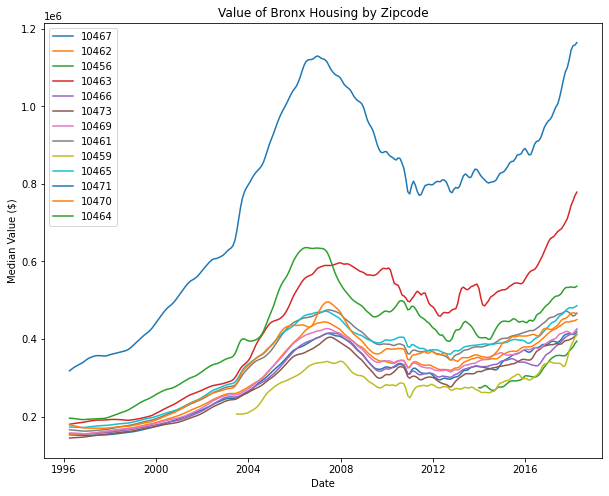

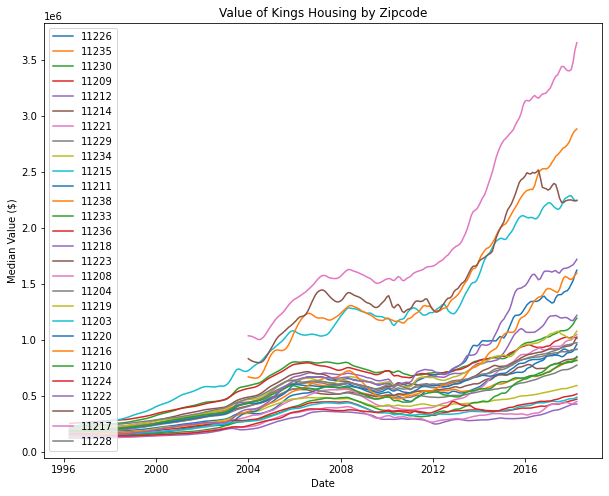

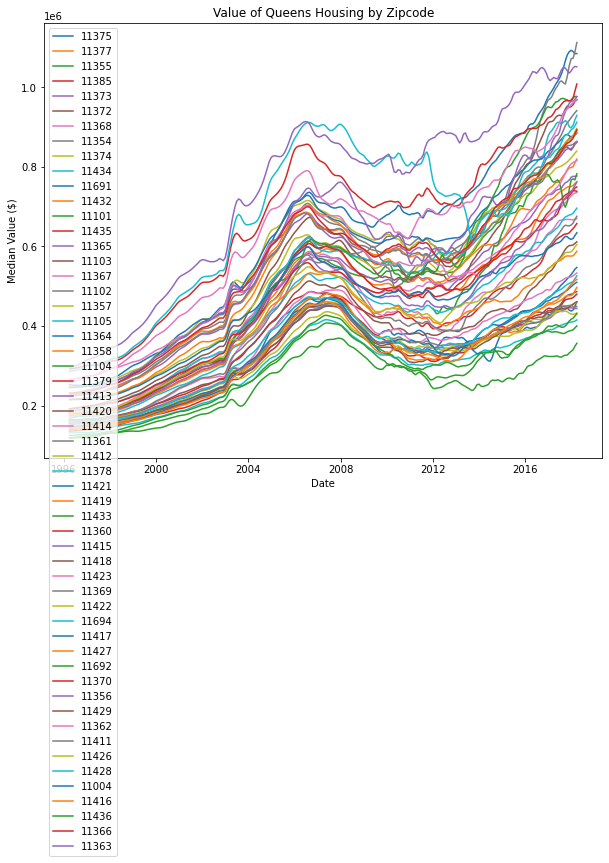

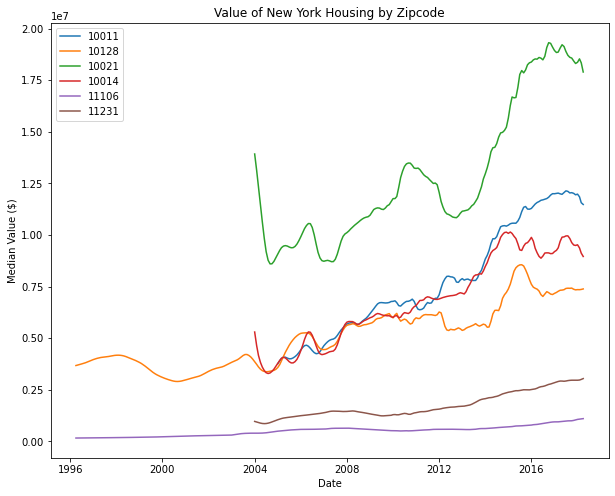

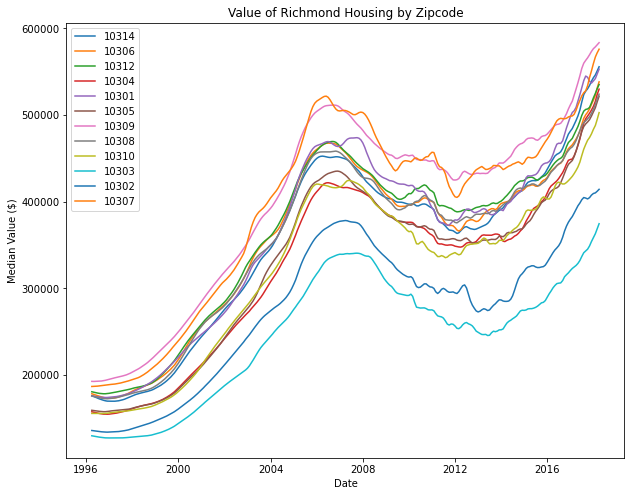

In [6]:
#Lets make a plot of each zip in each borough

for county in df.CountyName.unique():
    plt.figure(figsize=(10,8))
    plt.xlabel('Date')
    plt.ylabel('Median Value ($)')
    plt.title(f'Value of {county} Housing by Zipcode')
    
    temp_df=df[df.CountyName==county]
    for ind in temp_df.index:
        melt_df=melt_data(temp_df[temp_df.index==ind])
        plt.plot(melt_df,label=ind)
        plt.legend()
    plt.show()

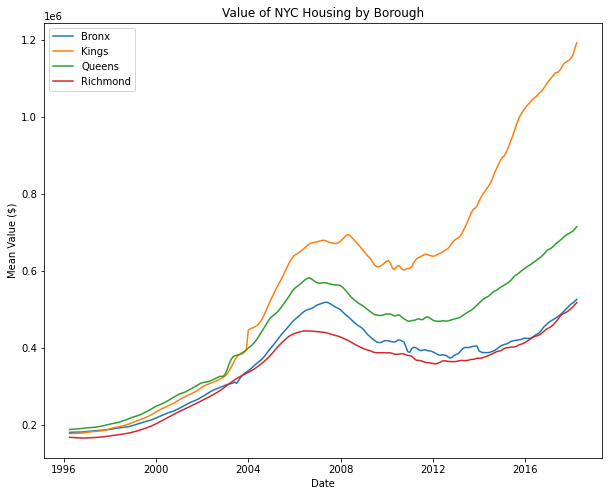

In [7]:
#Wowee! Not what I expected! Keep in mind we are looking for return on investment
#which means that we are less interested in absolute price as opposed to
#how much we think the value will grow

#based on the graphs, Manhattan is stagnant, while Brooklyn,Queens the Bronx and Staten Island (Im just as surprised as you)
#are rapidly appreciating in value.

df=df[df.CountyName.isin(['Richmond','Kings','Bronx','Queens'])]

Borough_df=df.groupby('CountyName')

plt.figure(figsize=(10,8))
plt.xlabel('Date')
plt.ylabel('Mean Value ($)')
plt.title('Value of NYC Housing by Borough')

for key,borough in Borough_df:
    plt.plot(melt_data(borough),label=key)
    plt.legend()
plt.show()

In [8]:
#Even though the graphs looked flat when plotted against Manhattan, they are clearly skyrocketing in value!
#Additionally, Manhattan flatlined and even sank over the last few years while these boroughs did not


#lets do a trial run


ts=melt_data(df[df.index==11224])

print(eval_arima(ts.values,[0,0,0]))

print(arima_gridsearch(ts.values,range(0,3),range(0,3),range(0,3)))

21247920544.27938
Arima(0, 0, 0) MSE=21247920544.27938
Arima(0, 0, 1) MSE=5409407192.663479
Arima(0, 1, 0) MSE=10692968.45202281
Arima(0, 1, 1) MSE=4594397.810840129
Arima(0, 1, 2) MSE=2238834.437104046
Arima(0, 2, 0) MSE=4428448.913024769
Arima(0, 2, 1) MSE=3530518.004936827
Arima(0, 2, 2) MSE=4254773.254215158
Arima(1, 0, 0) MSE=15467594.388722798
Arima(1, 1, 0) MSE=3692377.0306106945
Arima(1, 1, 2) MSE=2410052.214044941
Arima(1, 2, 0) MSE=4521668.21552118
Arima(1, 2, 1) MSE=3570724.4832377047
Arima(1, 2, 2) MSE=2845138.4672681806
Arima(2, 0, 0) MSE=4142054.1037644166
Arima(2, 1, 0) MSE=3888638.153489224
Arima(2, 1, 1) MSE=3065641.618826694
Arima(2, 1, 2) MSE=2147290.4509398933
Arima(2, 2, 0) MSE=3069435.443810924
Arima(2, 2, 1) MSE=2870627.150757229
Arima(2, 2, 2) MSE=3245693.54575884
(2, 1, 2)


In [9]:
#This took far too long. For the sake of time I will only look at Brooklyn zipcodes
#A future project may be to look at the ROI of other boroughs (and other cities at that)
print(df.CountyName.value_counts())
Brooklyn_df=df[df.CountyName=='Kings']

Queens      55
Kings       28
Bronx       13
Richmond    12
Name: CountyName, dtype: int64


In [10]:
P=D=Q=range(0,4) #It is very unlikely any term in the order is greater than 3

Order_dict=dict() #Will store ARIMA best order results for each zipcode
count=0
for zipcode in Brooklyn_df.index:
    ts=melt_data(Brooklyn_df[Brooklyn_df.index==zipcode])
    print(count,zipcode)
    count+=1
    Best_pdq=arima_gridsearch(ts.values,P,D,Q)
    Order_dict[zipcode]=Best_pdq


0 11226
Arima(0, 0, 0) MSE=121696194659.15405
Arima(0, 0, 1) MSE=31072018885.249336
Arima(0, 1, 0) MSE=96778360.04679437
Arima(0, 1, 1) MSE=48485393.69415158
Arima(0, 1, 2) MSE=32819212.29027699
Arima(0, 1, 3) MSE=31894823.93586263
Arima(0, 2, 0) MSE=45403219.88988299
Arima(0, 2, 1) MSE=42903993.10227549
Arima(0, 2, 2) MSE=40748516.021506615
Arima(1, 0, 0) MSE=128412839.65090454
Arima(1, 1, 0) MSE=43368843.19447449
Arima(1, 1, 1) MSE=37043089.06909318
Arima(1, 1, 2) MSE=37615318.14995748
Arima(1, 2, 0) MSE=44621996.546581544
Arima(1, 2, 1) MSE=42570919.914741985
Arima(2, 0, 0) MSE=45020480.205146134
Arima(2, 1, 0) MSE=39099680.125186935
Arima(2, 1, 1) MSE=37363088.88984011
Arima(2, 1, 2) MSE=29651372.682435323
Arima(2, 2, 0) MSE=37309264.08131243
Arima(2, 2, 1) MSE=38157714.96162766
Arima(3, 0, 0) MSE=41505326.56315271
Arima(3, 1, 0) MSE=35865195.32677986
Arima(3, 1, 1) MSE=36501773.07509031
Arima(3, 2, 0) MSE=37961177.71333317
Arima(3, 2, 1) MSE=38322262.2905358
1 11235
Arima(0, 0, 0)

Arima(0, 2, 1) MSE=2712838.0003975118
Arima(0, 2, 2) MSE=3250590.5842984812
Arima(0, 2, 3) MSE=1881775.5573286847
Arima(1, 0, 0) MSE=26880963.97150682
Arima(1, 1, 0) MSE=2972348.3958523413
Arima(1, 1, 2) MSE=2408684.272408769
Arima(1, 1, 3) MSE=1925946.0400981943
Arima(1, 2, 0) MSE=3100681.4883051645
Arima(1, 2, 1) MSE=2829385.0707966187
Arima(1, 2, 3) MSE=1946625.6722465644
Arima(2, 1, 0) MSE=2868848.5715251775
Arima(2, 1, 1) MSE=2608380.6597980894
Arima(2, 1, 2) MSE=2109045.774323132
Arima(2, 1, 3) MSE=1949374.7094716637
Arima(2, 2, 0) MSE=2614407.026415246
Arima(2, 2, 1) MSE=2590573.9069025354
Arima(2, 2, 2) MSE=2226146.118838468
Arima(2, 2, 3) MSE=1936417.8036012875
Arima(3, 1, 0) MSE=2547975.00642876
Arima(3, 1, 1) MSE=2495218.1847133515
Arima(3, 1, 2) MSE=2054360.5713823708
Arima(3, 1, 3) MSE=1938635.275527624
Arima(3, 2, 0) MSE=2654016.252822039
Arima(3, 2, 1) MSE=2628545.812161962
Arima(3, 2, 2) MSE=2171348.2449101442
Arima(3, 2, 3) MSE=1964223.2807407423
8 11234
Arima(0, 0, 0)

Arima(2, 1, 0) MSE=41767434.923668094
Arima(2, 1, 1) MSE=40504679.51763275
Arima(2, 1, 2) MSE=29919085.771486953
Arima(2, 1, 3) MSE=30901237.23589577
Arima(2, 2, 0) MSE=42202753.458428115
Arima(2, 2, 1) MSE=42885699.991609536
Arima(2, 2, 3) MSE=30604129.17190854
Arima(3, 1, 0) MSE=39403328.552757785
Arima(3, 1, 1) MSE=39865960.35689214
Arima(3, 1, 2) MSE=30132718.513588034
Arima(3, 2, 0) MSE=43157827.22648039
Arima(3, 2, 1) MSE=43496064.600888155
Arima(3, 2, 2) MSE=34478763.7149157
15 11223
Arima(0, 0, 0) MSE=115228762953.8306
Arima(0, 0, 1) MSE=29434943899.387474
Arima(0, 1, 0) MSE=55083237.97544017
Arima(0, 1, 1) MSE=22497739.452666204
Arima(0, 1, 3) MSE=10527710.098973548
Arima(0, 2, 0) MSE=14173106.058407852
Arima(0, 2, 1) MSE=11797541.337476663
Arima(0, 2, 2) MSE=13781232.634540508
Arima(0, 2, 3) MSE=9840782.737911833
Arima(1, 0, 0) MSE=83574895.99954394
Arima(1, 1, 0) MSE=14594599.25057227
Arima(1, 1, 3) MSE=9734929.664839227
Arima(1, 2, 0) MSE=12684032.411512025
Arima(1, 2, 1) M

Arima(1, 2, 1) MSE=88437215.21757792
Arima(2, 1, 0) MSE=90166749.96927385
Arima(2, 1, 1) MSE=70472221.64190218
Arima(2, 2, 0) MSE=70010325.08240174
Arima(2, 2, 1) MSE=73316703.56289814
Arima(3, 1, 0) MSE=65277597.67260686
Arima(3, 1, 1) MSE=65855303.781711094
Arima(3, 2, 0) MSE=71985674.98058397
Arima(3, 2, 1) MSE=71883441.99605776
22 11210
Arima(0, 0, 0) MSE=63343411482.863686
Arima(0, 0, 1) MSE=16181986676.5743
Arima(0, 1, 0) MSE=29708364.75434088
Arima(0, 1, 1) MSE=10358572.632763376
Arima(0, 2, 0) MSE=8912020.078655489
Arima(0, 2, 1) MSE=5755199.9701187955
Arima(0, 2, 2) MSE=5525096.328012651
Arima(1, 0, 0) MSE=46919469.76190423
Arima(1, 1, 0) MSE=8313836.600514408
Arima(1, 1, 1) MSE=5128263.5985677615
Arima(1, 1, 2) MSE=4543735.428902219
Arima(1, 1, 3) MSE=4095070.3004580685
Arima(1, 2, 0) MSE=6703124.434045506
Arima(1, 2, 1) MSE=5662877.968158614
Arima(2, 0, 0) MSE=8668625.104468348
Arima(2, 0, 1) MSE=5422949.690308348
Arima(2, 0, 2) MSE=4946622.248155532
Arima(2, 0, 3) MSE=41262

In [11]:
for key,val in Order_dict.items():
    print(key,val)
    


11226 (2, 1, 2)
11235 (1, 1, 3)
11230 (2, 2, 3)
11209 (3, 1, 2)
11212 (2, 1, 2)
11214 (2, 1, 2)
11221 (1, 2, 3)
11229 (0, 2, 3)
11234 (0, 2, 3)
11215 (2, 2, 3)
11211 (0, 1, 3)
11238 (2, 1, 0)
11233 (3, 1, 0)
11236 (1, 1, 3)
11218 (2, 1, 2)
11223 (1, 1, 3)
11208 (1, 1, 3)
11204 (3, 1, 3)
11219 (0, 1, 3)
11203 (0, 2, 3)
11220 (2, 1, 2)
11216 (1, 1, 2)
11210 (2, 1, 2)
11224 (2, 1, 3)
11222 (3, 1, 3)
11205 (0, 1, 2)
11217 (0, 1, 3)
11228 (2, 1, 3)


In [12]:
#due to error, one of the values must be changed
Order_dict[11203]=(1,1,3)


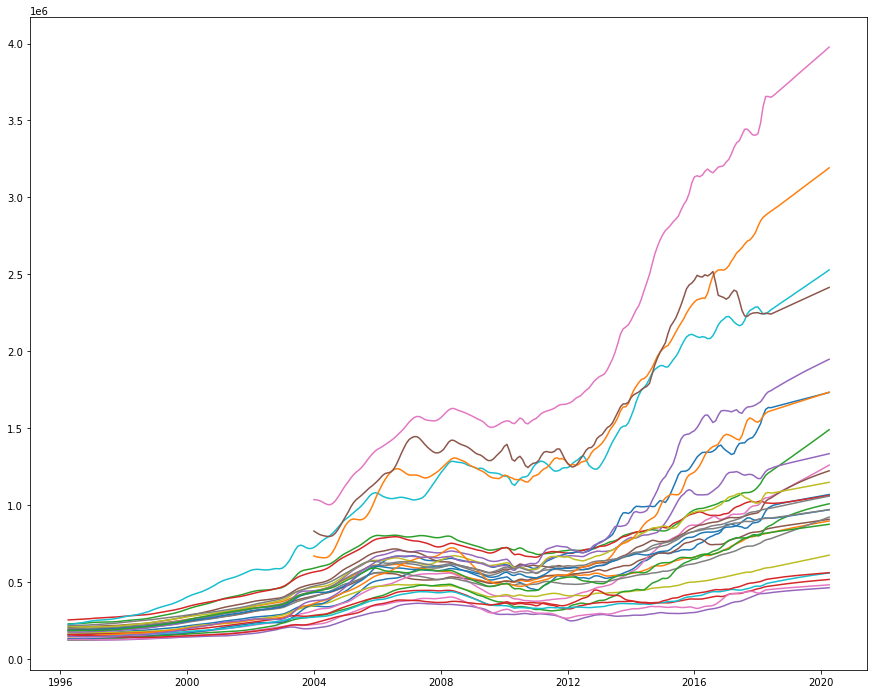

In [17]:
future=pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')
plt.figure(figsize=(15,12))

Forecast_dict={}

for key,val in Order_dict.items():
    ts=melt_data(Brooklyn_df[Brooklyn_df.index==key])
    model=ARIMA(ts,order=val)
    model_fit=model.fit(disp=0)
    forecast=model_fit.forecast(24)
    forecast_df=pd.DataFrame({'time':future,'value':forecast[0]})
    forecast_df.set_index('time', inplace = True)
    ts_forecast=pd.concat([ts,forecast_df])
    Forecast_dict[key]=ts_forecast
    plt.plot(ts_forecast)
    

plt.show()
    
    

In [18]:
#Cool, so now we have the graphs and we can see that most trends continued just as expected
#Lets calculate the ROIS



ROI=dict()

for zipcode,ts in Forecast_dict.items():
    Start=float(ts[ts.index=='2018-04-01'].value)
    End=float(ts[ts.index=='2020-04-01'].value)
    Percent_Increase=(End-Start)*100/Start
    ROI[zipcode]=Percent_Increase

sorted_ROI=sorted(ROI.items(), key=lambda x: x[1], reverse=True)
sorted_ROI


[(11230, 24.780091330727714),
 (11221, 20.271369746137438),
 (11223, 19.294306423144292),
 (11229, 19.161765801018916),
 (11233, 18.548341973192663),
 (11203, 14.56164147611755),
 (11234, 14.035364316006676),
 (11222, 13.225998034042032),
 (11215, 12.72476801138893),
 (11226, 11.1458730177616),
 (11238, 10.65116817466678),
 (11235, 10.08499305523886),
 (11236, 9.932676151136276),
 (11218, 9.397996584213544),
 (11217, 8.764984328404942),
 (11224, 8.652603823634713),
 (11204, 8.543783751460015),
 (11216, 8.542142911633475),
 (11212, 8.492273070212768),
 (11214, 7.7482515291063345),
 (11205, 7.437638912316574),
 (11208, 7.379627486144881),
 (11210, 7.018521567664704),
 (11211, 6.768693880538185),
 (11219, 6.510224319519817),
 (11228, 6.165296819821308),
 (11220, 5.875258180082887),
 (11209, 4.766474839375098)]

In [19]:
#The top 5 zipcodes to invest in, which will be worth the most in the next 2 years are:
# 11230, 11221, 11223,11233,11211
#How about the zop 5 zipcodes for every five years up to 50 years from now?


for years in [5*i for i in range(1,11)]:
    future=pd.date_range(start = '2018-05-01', periods= 12*years, freq = 'MS')
    
    ROIs=dict()
    
    for key,val in Order_dict.items():
        ts=melt_data(Brooklyn_df[Brooklyn_df.index==key])
        Start_val=float(ts[ts.index=='2018-04-01'].value)
        model=ARIMA(ts,order=val)
        model_fit=model.fit(disp=0)
        forecast=model_fit.forecast(12*years)
        forecast_df=pd.DataFrame({'time':future,'value':forecast[0]})
        forecast_df.set_index('time', inplace = True)
        ts_forecast=pd.concat([ts,forecast_df])
        End_val=float(ts_forecast.iloc[-1])
        roi=100*(End_val-Start_val)/Start_val
        ROIs[key]=roi
    sorted_ROI=sorted(ROIs.items(), key=lambda x: x[1], reverse=True)
    Top5=[x[0] for x in sorted_ROI[:5]]
    print(f'In {years} years, the most valuable zipcodes will be {Top5}')


In 5 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11223]
In 10 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 15 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 20 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 25 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 30 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 35 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 40 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 45 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
In 50 years, the most valuable zipcodes will be [11230, 11221, 11229, 11234, 11215]
